# 투자성향기반 변액펀드 추천
고객의 특성을 파악할 수 있는 기존 변수 및 파생 변수를 이용해 클러스터링을 진행하였습니다. 고객그룹을 클러스터별로 구분하여 클러스터별 특징을 파악하고 클러스터별로 선호하는 펀드와 관련 키워드를 추출하였습니다. 이를 이용하여 태블로 대시보드에서 고객이 자신의 투자성향을 파악하고 이에 맞는 펀드를 추천받을 수 있도록 했습니다. 


[목차]

1.  파생변수 생성

2. 클러스터링(k-means clustering)
  - 클러스터링 변수 선택
  - 변수 정규화
  - 최적의 클러스터 개수 찾기
  - K-means clustering
  - 클러스터 해석
  - 클러스터별 시계열 추이 비교


3. 클러스터별 선호 펀드 파악
  - 최빈 거래 펀드
  - 최다 그룹 거래 펀드
  - 클러스터별 선호 펀드 스타일

4. 태블로 시각화용 데이터셋 완성
  - 클러스터 정보 
  - 펀드 및 키워드 시각화를 위한 전처리
  - 클러스터 예측

In [192]:
import pandas as pd
import numpy as np
import os
import math
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm
from sklearn.cluster import KMeans 
from sklearn import preprocessing
import random
import ast
import collections

In [193]:
# seed값 고정 
seed = 0
random.seed(seed)
np.random.seed(seed)

In [194]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [195]:
# 데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/miraeasset/mali_data1.csv')

### 1. 파생변수 생성

그룹ID별 특징을 파악할 수 있는 파생변수 생성

- 그룹ID별로 거래한 펀드의 종류의 유니크 개수


In [196]:
# GID 별 펀드 종류 개수 변수 생성
fund_cd_num = data.loc[:, ['gid', 'fund_cd', 'fund_stle_cd']].drop_duplicates(['gid', 'fund_cd', 'fund_stle_cd'])
fund_cd_num = fund_cd_num.groupby('gid').count().loc[:, ['fund_cd']]
fund_cd_num.rename(columns = {'fund_cd' : 'fund_cd_num'}, inplace = True)
fund_cd_num

,fund_cd_num
gid,
2214.0,26
5358.0,56
20540.0,19
23953.0,83
33984.0,61
...,...
9982667.0,56
9986583.0,25
9988743.0,14


- 그룹ID별로 거래한 펀드의 스타일코드 종류의 유니크 개수

In [197]:
# GID별 펀드 스타일코드 개수 변수 생성
fund_stle_num = data.loc[:, ['gid', 'fund_stle_cd']].drop_duplicates(['gid', 'fund_stle_cd'])
fund_stle_num = fund_stle_num.groupby('gid').count()
fund_stle_num.rename(columns = {'fund_stle_cd' : 'fund_stle_num'}, inplace = True)
fund_stle_num

,fund_stle_num
gid,
2214.0,11
5358.0,17
20540.0,8
23953.0,16
33984.0,15
...,...
9982667.0,17
9986583.0,15
9988743.0,9


In [198]:
# 데이터에 파생변수 병합
data = pd.merge(data, fund_cd_num, left_on = 'gid', right_on = 'gid', how = 'left')
data = pd.merge(data, fund_stle_num, left_on = 'gid', right_on = 'gid', how = 'left')

- 그룹별 거래한 펀드 중 주식형 펀드의 비율 

In [199]:
# 주식형 펀드 비율 변수 생성
data['fund_diff_cd'] = np.where(data['fund_diff_cd'] == 2 | 3, 1, 0) # 주식형 또는 주식혼합형 펀드의 경우 1 변환
fund_ratio =  data.groupby('gid').sum()/data.groupby('gid').count()
fund_ratio = fund_ratio['fund_diff_cd']
fund_ratio = fund_ratio.reset_index()
fund_ratio.rename(columns = {'fund_diff_cd': 'fund_ratio'}, inplace = True)
fund_ratio.head()

,gid,fund_ratio
0,2214.0,0.153846
1,5358.0,0.195440
2,20540.0,0.473684
3,23953.0,0.161491
4,33984.0,0.225434


In [200]:
# 데이터에 병합
data = pd.merge(data, fund_ratio, how = 'left', left_on = 'gid', right_on = 'gid')
data.head(3)

,gid,base_ym,product_cd,age_cd,channel_cd,gender,job_cd,pay_prd,loan_yn,rider,rcpt_cd,cntr_cnt,signgu_cd,avg_jn_amt,avg_cssc,sum_fee_amt,avg_max_pay,avg_ch_cntr_cnt,cntr_no_cnt,fund_avg_income_ratio,fund_min_income_ratio,fund_1q_income_ratio,fund_med_income_ratio,fund_3q_income_ratio,fund_max_income_ratio,fund_cd,avg_ch_fund_ratio,avg_bs_fund_ratio,avg_add_fund_ratio,in_fund_cnt,sum_in_fund_amt,min_in_fund_amt,max_in_fund_amt,med_in_fund_amt,avg_in_fund_amt,sum_in_fund_atcnt,min_in_fund_atcnt,max_in_fund_atcnt,med_in_fund_atcnt,avg_in_fund_atcnt,wd_fund_cnt,sum_wd_fund_amt,min_wd_fund_amt,max_wd_fund_amt,med_wd_fund_amt,avg_wd_fund_amt,sum_wd_fund_atcnt,min_wd_fund_atcnt,max_wd_fund_atcnt,med_wd_fund_atcnt,avg_wd_fund_atcnt,fund_price,fund_nm,fund_set_dt,operation_rsk,operation_conm,fund_expln,stck_expln,finan_bond_expln,fund_aset_cd,fund_stle_cd,insur_as_fund_cd,fund_diff_cd,finan_bond_cd,feh_cd,fund_cd_num,fund_stle_num,fund_ratio
0,7766143.0,2020-11,2,41_55,2,0,B,1,0,1,1,1,1,4467,500,655,75,11.0,15,17.54,2.56,7.5,16.0,21.0,45.63,N2C0,NaN,NaN,NaN,1,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1313.65,아시아인프라,20080415,3,이스트스프링자산운용,자산의 60% 이상을 아시아 국가의 인프라관련 주식 및 아시아국가 인프라 주식을 주...,60% 이상을 아시아 각국의 인프라 산업과 관련된 주식 및 주식형 펀드,"40% 이내에서 현예금(외화 현예금 포함), MMF 등을 포함한 유동성 자산",8,6,KLVL3400W15,0,2,2,31,15,0.052288
1,7766143.0,2020-03,2,41_55,2,0,B,1,0,1,1,1,1,4467,500,655,75,11.0,15,9.82,0.12,4.0,8.0,12.5,27.71,N5A0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1438.67,MMF형,20040607,5,KB자산운용,"MMF형 펀드, 콜론 등의 단기유동성 금융자산에 90% 이상 투자",투자하지 않음,단기유동성 금융자산,4,9,KLVL3400V14,0,1,2,31,15,0.052288
2,7766143.0,2020-05,2,41_55,2,0,B,1,0,1,1,1,1,4467,500,655,75,11.0,15,5.70,-11.87,1.0,5.0,10.5,19.89,N1B0,NaN,NaN,NaN,1,11.0,11.0,11.0,11.0,11.0,5.0,5.0,5.0,5.0,5.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2388.41,혼합형,20040607,3,교보악사자산운용,"자산의 50%를 주식 및 주식형펀드, 50%를 채권 및 채권형펀드에 투자","50%를 주식 및 주식형 펀드, 20% 범위 내에서 증감이 가능","50%를 채권 및 채권형 펀드, 20% 범위 내에서 증감이 가능, 현예금, MMF ...",1,2,KLVL3400V12,1,2,2,31,15,0.052288


### 2. 클러스터링

#### 클러스터 변수 선택
고객 그룹을 유의미하게 구별할 수 있는 변수를 선택했습니다.

- 데이터 간의 거리를 정확히 구할 수 있도록 범주형 변수를 제외하였고, 수익률은 펀드 특성상 큰 차이가 없다고 판단하여 제외했습니다.
- 결측비율이 높은 변수도 제외했습니다.

In [201]:
# 투자 성향에 관련된 변수만 선택
select_var = data.loc[:,['gid','cntr_cnt', 'avg_cssc','avg_ch_cntr_cnt', 'cntr_no_cnt','avg_max_pay','avg_jn_amt','sum_fee_amt','operation_rsk',
           'avg_ch_fund_ratio','avg_bs_fund_ratio','avg_add_fund_ratio','in_fund_cnt','sum_in_fund_amt','avg_in_fund_amt','sum_in_fund_atcnt','avg_in_fund_atcnt',
            'wd_fund_cnt','sum_wd_fund_amt','avg_wd_fund_amt','sum_wd_fund_atcnt','avg_wd_fund_atcnt', 'fund_cd', 'fund_ratio', 'fund_cd_num', 'fund_stle_num']]

In [202]:
# 결측치가 많은 변수 제외
select_var.isnull().sum()

gid                         0
cntr_cnt                    0
avg_cssc                    0
avg_ch_cntr_cnt             0
cntr_no_cnt                 0
avg_max_pay                 0
avg_jn_amt                  0
sum_fee_amt                 0
operation_rsk               0
avg_ch_fund_ratio      976130
avg_bs_fund_ratio      984645
avg_add_fund_ratio    1043992
in_fund_cnt                 0
sum_in_fund_amt        276362
avg_in_fund_amt        276362
sum_in_fund_atcnt      276362
avg_in_fund_atcnt      276362
wd_fund_cnt                 0
sum_wd_fund_amt         12635
avg_wd_fund_amt         12635
sum_wd_fund_atcnt       12635
avg_wd_fund_atcnt       12635
fund_cd                     0
fund_ratio                  0
fund_cd_num                 0
fund_stle_num               0
dtype: int64

In [203]:
select_var = select_var[select_var.columns.difference(['avg_ch_fund_ratio','avg_bs_fund_ratio', 'avg_add_fund_ratio'])]

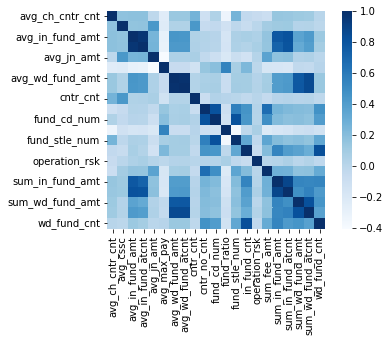

In [204]:
# 변수별 상관관계 plot
corr = select_var[select_var.columns.difference(['gid'])].corr(method = 'pearson')
df_heatmap = sns.heatmap(corr, cbar = True, square = True, cmap = 'Blues')

상관관계가 커보이는 변수가 있어 보여서  정확한 상관계수를 확인했습니다.

In [205]:
# 상관계수가 절댓값 0.7 이상인 변수들 추출
corr[abs(corr) >= 0.7]

,avg_ch_cntr_cnt,avg_cssc,avg_in_fund_amt,avg_in_fund_atcnt,avg_jn_amt,avg_max_pay,avg_wd_fund_amt,avg_wd_fund_atcnt,cntr_cnt,cntr_no_cnt,fund_cd_num,fund_ratio,fund_stle_num,in_fund_cnt,operation_rsk,sum_fee_amt,sum_in_fund_amt,sum_in_fund_atcnt,sum_wd_fund_amt,sum_wd_fund_atcnt,wd_fund_cnt
avg_ch_cntr_cnt,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_cssc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_in_fund_amt,NaN,NaN,1.000000,0.965459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.782560,0.817013,NaN,NaN,NaN
avg_in_fund_atcnt,NaN,NaN,0.965459,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.721096,0.803871,NaN,NaN,NaN
avg_jn_amt,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_max_pay,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_wd_fund_amt,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.987893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.776444,0.858153,NaN
avg_wd_fund_atcnt,NaN,NaN,NaN,NaN,NaN,NaN,0.987893,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.786000,0.862178,NaN
cntr_cnt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cntr_no_cnt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.817207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


상관계수가 높은 변수들을 살펴보면 크게 투입 관련 변수, 인출 관련 변수, 펀드 종류 개수 관련 변수, 금액 관련 변수로 볼 수 있다. 이를 반영할 수 있으면서 서로 상관성이 높지 않은 변수들로 '평균 편드 변경 건수', '펀드 종류 개수', '평균 가입금액'을 선택했습니다.
  
  또한 투자 성향을 가장 잘 보여줄 수 있는 것이 리스크 감수 측면이라고 판단해 이를 고려할 수 있는 '주식형 펀드 비율'을 추가로 선택하였습니다.

In [206]:
# 최종 변수 선택
cluster_data = data.loc[:, ['gid', 'avg_ch_cntr_cnt', 'fund_cd_num', 'avg_jn_amt', 'fund_ratio']]
cluster_data = cluster_data.groupby('gid').mean().reset_index()
cluster_data.head(3)

,gid,avg_ch_cntr_cnt,fund_cd_num,avg_jn_amt,fund_ratio
0,2214.0,0.0,26,3163,0.153846
1,5358.0,4.0,56,2839,0.195440
2,20540.0,0.0,19,6123,0.473684


#### 변수 정규화
클러스터링에 사용할 변수들을 MinMaxSclaler를 이용해 스케일링 해주었습니다. 

In [207]:
# 클러스터링을 위해 정규화
result_cluster = cluster_data.copy()

scaler = preprocessing.MinMaxScaler()
result_cluster = scaler.fit_transform(result_cluster[result_cluster.columns.difference(['gid'])])

In [208]:
result_cluster = pd.DataFrame(result_cluster, columns=['avg_ch_cntr_cnt', 'fund_cd_num', 'avg_jn_amt', 'fund_ratio'])
result_cluster.head(3)

,avg_ch_cntr_cnt,fund_cd_num,avg_jn_amt,fund_ratio
0,0.0,0.040341,0.209524,0.153846
1,0.2,0.035611,0.495238,0.195440
2,0.0,0.083558,0.142857,0.473684


#### 최적의 클러스터 개수 찾기
WSS값과 Silhouette값을 고려하여 최적의 클러스터 개수를 4개로 결정했습니다.

In [209]:
# elbow point를 알 수 있는 함수 구현

def elbow(X):
  sse = []
  for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

  plt.plot(range(1,11), sse, marker = 'o')
  plt.xlabel('number of cluster')
  plt.ylabel('SSE')
  plt.show()

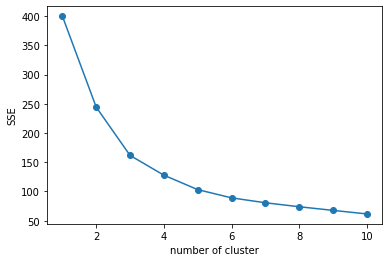

In [210]:
elbow(result_cluster)

scree plot에서 elbow point는 3으로 총 4개의 클러스터가 적절한 것으로 보입니다.

In [211]:
# 실루엣계수를 그래프로 알 수 있는 함수 구현

def plotSilhouette(X, y_km):
  cluster_labels = np.unique(y_km)
  n_clusters = cluster_labels.shape[0]
  silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
  y_ax_lower, y_ax_upper = 0, 0
  yticks = []

  for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i/n_clusters)

    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0, edgecolor = 'none', color = color)
    yticks.append((y_ax_lower + y_ax_upper)/2)
    y_ax_lower += len(c_silhouette_vals)

  silhouette_avg = np.mean(silhouette_vals)
  print(silhouette_avg)
  plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
  plt.yticks(yticks, cluster_labels+1)
  plt.ylabel('cluster')
  plt.xlabel('Silhouette')
  plt.show()

0.4009121394818261


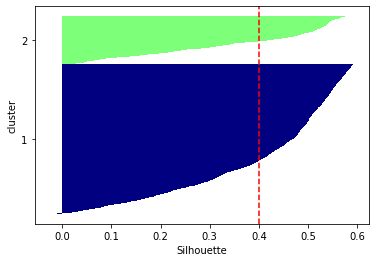

0.3783953577243336


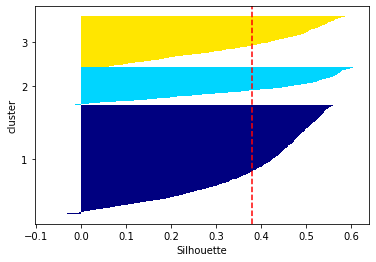

0.3388929624899666


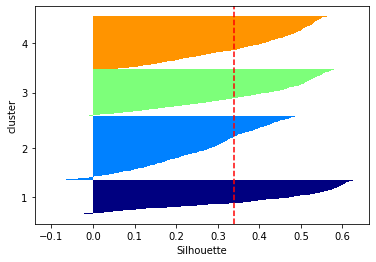

0.3379026150253755


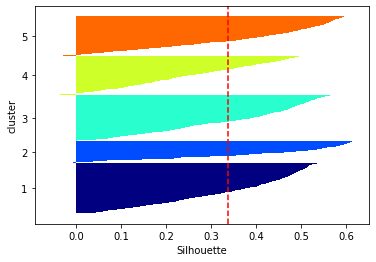

0.332146905492311


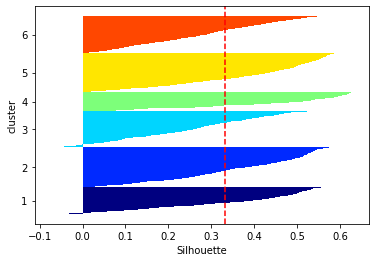

0.33321313240815453


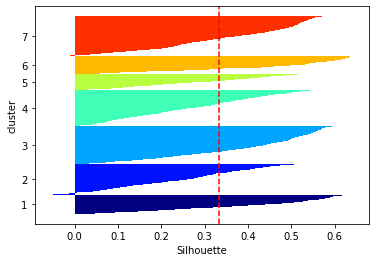

In [212]:
for i in range(2, 8):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state=0)
    y_km = km.fit_predict(result_cluster)
    plotSilhouette(result_cluster, y_km)

클러스터가 개수가 적을수록 실루엣 계수가 더 크지만, 클러스터 크기 불균형과 SSE값을 고려하여 최종적으로 클러스터 개수를 4개로 결정했습니다.

#### K-means Clustering

In [213]:
# K-means clustering
km = KMeans(n_clusters = 4, init = 'k-means++', random_state=0)
y_km = km.fit_predict(result_cluster)

In [214]:
# cluster column 추가
cluster_data['cluster'] = y_km
cluster_data

,gid,avg_ch_cntr_cnt,fund_cd_num,avg_jn_amt,fund_ratio,cluster
0,2214.0,0.0,26,3163,0.153846,1
1,5358.0,4.0,56,2839,0.195440,2
2,20540.0,0.0,19,6123,0.473684,3
3,23953.0,2.0,83,2992,0.161491,2
4,33984.0,6.0,61,4340,0.225434,2
...,...,...,...,...,...,...
3057,9982667.0,13.0,56,1773,0.114726,0
3058,9986583.0,3.0,25,1679,0.127660,1
3059,9988743.0,0.0,14,1714,0.357143,3
3060,9991983.0,11.0,22,6715,0.063830,0


In [215]:
# 클러스터 크기
cluster_data.groupby(['cluster']).count()

,gid,avg_ch_cntr_cnt,fund_cd_num,avg_jn_amt,fund_ratio
cluster,,,,,
0,520,520,520,520,520
1,997,997,997,997,997
2,723,723,723,723,723
3,822,822,822,822,822


In [216]:
# 클러스터 평균값
cluster_data.drop('gid', axis=1).groupby(['cluster']).mean()

,avg_ch_cntr_cnt,fund_cd_num,avg_jn_amt,fund_ratio
cluster,,,,
0,14.988462,34.042308,3456.238462,0.126371
1,3.656971,25.518556,4054.298897,0.120325
2,4.962656,64.799447,3045.154910,0.198285
3,1.682482,22.312652,3044.208029,0.386832


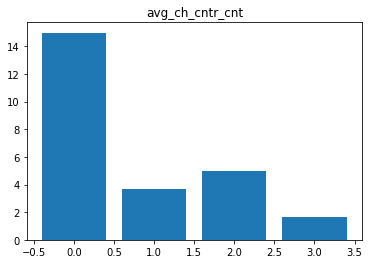

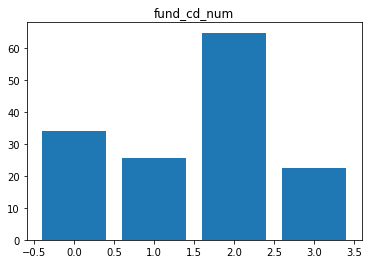

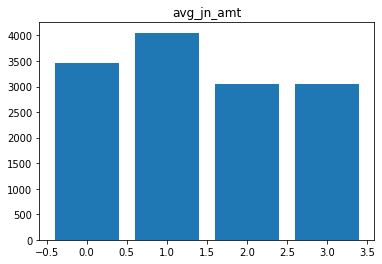

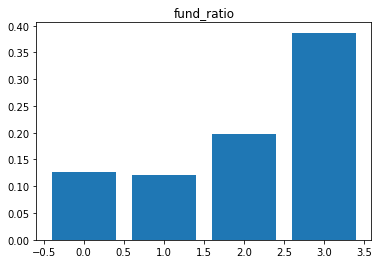

In [217]:
# 클러스터별 평균값 시각화
clusters_mean = cluster_data.groupby(['cluster']).mean()

for c in range(clusters_mean.shape[1]-1):
  plt.bar(clusters_mean.index, clusters_mean.iloc[:,c+1])
  plt.title("{}".format(clusters_mean.columns[c+1]))
  plt.show()


1. '클러스터 0'이 펀드 변경 건수가 압도적으로 높다.
2. '클러스터 2'가 펀드 종류가 가장 다양하다.
3. '클러스터 1'이 가입 금액이 가장 크다.
4. '클러스터 3'이 주식형 펀드 비율이 압도적으로 높다.

#### 클러스터 해석

In [218]:
# 클러스터별 모든 변수 확인
cluster_num = cluster_data.loc[:, ['gid', 'cluster']]
data = pd.merge(data, cluster_num, how = 'left', left_on= 'gid', right_on = 'gid')
data.groupby(['cluster']).mean()

,gid,product_cd,channel_cd,gender,pay_prd,loan_yn,rider,rcpt_cd,cntr_cnt,signgu_cd,avg_jn_amt,avg_cssc,sum_fee_amt,avg_max_pay,avg_ch_cntr_cnt,cntr_no_cnt,fund_avg_income_ratio,fund_min_income_ratio,fund_1q_income_ratio,fund_med_income_ratio,fund_3q_income_ratio,fund_max_income_ratio,avg_ch_fund_ratio,avg_bs_fund_ratio,avg_add_fund_ratio,in_fund_cnt,sum_in_fund_amt,min_in_fund_amt,max_in_fund_amt,med_in_fund_amt,avg_in_fund_amt,sum_in_fund_atcnt,min_in_fund_atcnt,max_in_fund_atcnt,med_in_fund_atcnt,avg_in_fund_atcnt,wd_fund_cnt,sum_wd_fund_amt,min_wd_fund_amt,max_wd_fund_amt,med_wd_fund_amt,avg_wd_fund_amt,sum_wd_fund_atcnt,min_wd_fund_atcnt,max_wd_fund_atcnt,med_wd_fund_atcnt,avg_wd_fund_atcnt,fund_price,fund_set_dt,operation_rsk,fund_aset_cd,fund_stle_cd,fund_diff_cd,finan_bond_cd,feh_cd,fund_cd_num,fund_stle_num,fund_ratio
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.436591e+06,1.896663,1.446796,0.557806,0.639668,0.101934,0.293179,0.721094,2.678864,2.021498,3339.349294,1084.621205,1954.326700,53.520891,14.857792,35.565025,18.215775,-2.168998,9.093585,15.644224,23.950667,55.622174,23.211178,22.787692,24.544341,1.843796,116.156856,34.874307,81.743989,56.609319,58.353439,151.653681,8.532284,105.161115,22.192325,50.997120,7.326210,18.434052,1.804137,11.539869,2.478019,11.884642,79.316781,0.0,23.242014,0.0,6.940879,1647.481499,2.011274e+07,3.072156,6.606543,8.806987,0.124411,1.744060,1.628542,39.599011,14.737224,0.124411
1,4.893379e+06,1.770470,1.795278,0.550430,0.759701,0.180093,0.305102,0.760783,2.000620,2.111869,3880.173747,829.461917,2077.054234,60.039224,3.838060,24.964466,16.845438,-0.261774,8.605053,14.528225,21.800504,48.361589,27.964105,27.319231,30.625108,1.570426,63.020559,19.935313,43.648392,29.381716,31.115863,67.542995,6.879788,47.379326,13.746338,25.053398,5.957343,9.298029,0.769207,5.824210,1.037163,5.057688,30.924156,0.0,10.133488,0.0,2.944462,1661.091994,2.011037e+07,3.086987,6.483640,8.726911,0.124674,1.758013,1.610508,29.114976,12.775254,0.124674
2,4.898663e+06,1.528639,1.440721,0.636199,0.951073,0.088419,0.122377,0.946941,2.170472,2.152242,2995.321747,746.643463,8586.287156,85.118525,4.876075,179.844488,17.941247,-4.365202,9.808394,16.056565,23.179088,67.055024,25.679589,25.232429,27.685503,4.264599,107.629045,10.008367,64.246624,19.420129,31.254355,128.304767,4.188315,77.791831,9.919331,24.970765,12.239537,18.621468,0.509515,11.381136,0.746781,7.966764,76.302322,0.0,22.596583,0.0,4.776061,1577.039230,2.011035e+07,3.212810,6.365607,8.623391,0.195503,1.782327,1.536563,68.711190,16.493585,0.195503
3,5.015535e+06,1.277226,1.516002,0.563337,0.983677,0.231441,0.085903,0.930356,2.013208,2.089843,2992.901051,648.419805,857.641880,93.191779,1.741202,25.554476,19.392824,3.899122,11.706836,17.395250,24.249206,44.814429,29.626461,29.019011,32.889991,1.554044,38.155676,11.853273,26.650599,17.637501,19.509434,36.755694,5.688753,26.815960,9.355393,14.892326,4.668511,5.724745,0.494517,3.581052,0.827675,3.454720,18.968570,0.0,6.482543,0.0,1.996149,1654.538607,2.009948e+07,3.317535,5.994638,7.674625,0.364027,1.851307,1.429235,26.243981,10.771871,0.364027


__클러스터별 차이가 보이는 변수__  

- avg_cssc(VIP 점수): '클러스터 0'이 압도적으로 높음.
- sum_fee_amt(월납 보험료의 합계): '클러스터 2'가 압도적으로 높으며, '클러스터 3'이 눈에 띄게 작음.
- avg_max_pay(최종 납입횟수의 평균): 클러스터 간의 단계적 차이 존재.
- cntr_no_cnt(보험계약건수): '클러스터 2'가 압도적으로 높지만, 변수 특성상 사람이 많다면 클 수밖에 없기 때문에 절대적인 차이를 알 수 없어 고려하지 않음.
- in_fund_cnt(투입 건수): '클러스터 2'가 눈에 띄게 많음.
- sum_in_fund_amt: 투입 건수는 '클러스터 2'가 더 많지만, 투입 금액은 '클러스터 0'이 더 많은 걸 알 수 있음. 이는 '클러스터 0'이 한 번에 많은 금액을 투입한다는 것을 의미함.  
- wd_fund_cnt(인출 건수): 인출 역시 투입과 비슷한 결과.

이렇게 클러스터 간의 차이를 정리한 결과입니다.  
- **클러스터 0**: MVIP(Mirae Asset VIP)형 => VIP 점수가 높으며 투입과 인출의 금액이 큰 소수의 집단
- **클러스터 1**: 보험중심형 => 가장 안정적으로 투자하는, 보험을 보험답게 하는 집단
- **클러스터 2**: 다다익선형 => 다양한 펀드에 투자하는 적극적인 집단
- **클러스터 3**: 주식중심형 => 적은 금액이지만 가장 공격적인 투자를 하는 집단

#### 클러스터별 시계열 데이터  추이 비교


In [219]:
# 기준년월 데이터 날짜형으로 전환
data['base_ym'] = pd.to_datetime(data['base_ym'])

- 수익률 추이

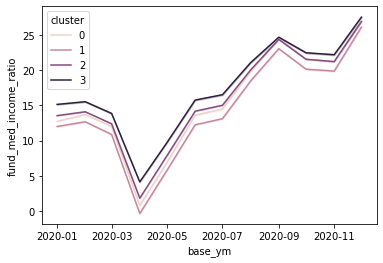

In [220]:
# 클러스터별 수익률 중간값 추이
sns.lineplot(x = "base_ym", y = "fund_med_income_ratio", hue = "cluster", data = data)

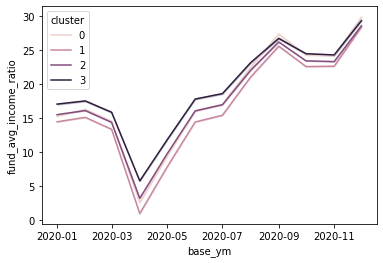

In [221]:
# 클러스터별 수익률 평균 추이
sns.lineplot(x = "base_ym", y = "fund_avg_income_ratio", hue = "cluster", data = data)

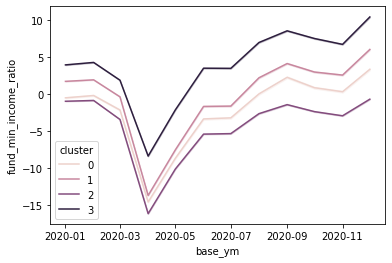

In [222]:
# 클러스터별 수익률 최솟값 추이
sns.lineplot(x = "base_ym", y = "fund_min_income_ratio", hue = "cluster", data = data)

수익률에서는 클러스터별로 수익률 추이가 비슷한 양상으로 나타납니다. 

- 투입 관련 변수 추이

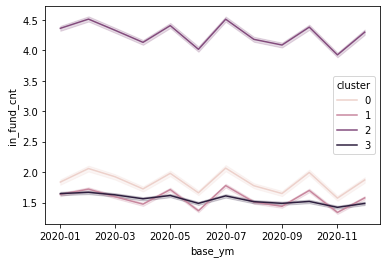

In [223]:
# 클러스터별 투입건수 추이
sns.lineplot(x = "base_ym", y = "in_fund_cnt", hue = "cluster", data = data)

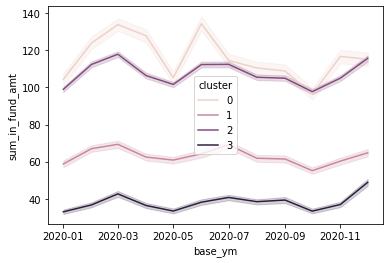

In [224]:
# 클러스터별 투입금액합계 추이
sns.lineplot(x = "base_ym", y = "sum_in_fund_amt", hue = "cluster", data = data)

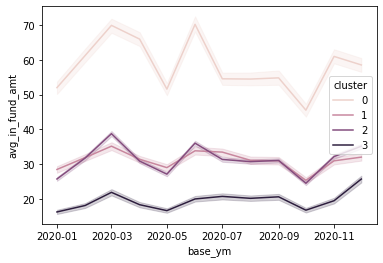

In [225]:
# 클러스터별 투입금액평균 추이
sns.lineplot(x = "base_ym", y = "avg_in_fund_amt", hue = "cluster", data = data)

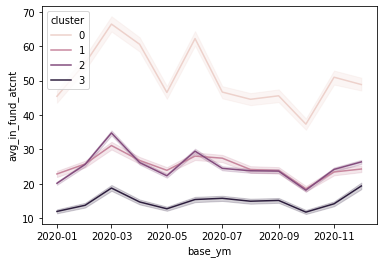

In [226]:
# 클러스터별 투입좌수평균 추이
sns.lineplot(x = "base_ym", y = "avg_in_fund_atcnt", hue = "cluster", data = data)

클러스터 간에 양상의 차이는 거의 없지만, '클러스터 0'이 금액 단위가 커 가장 변화폭이 뚜렷하게 나타나는 것을 확인할 수 있습니다.

- 인출 관련 변수 추이

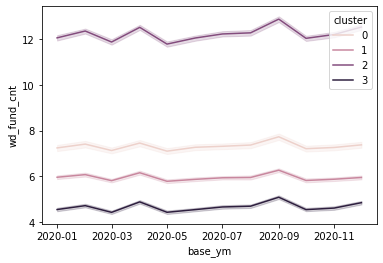

In [227]:
# 클러스터별 인출이체건수 추이
sns.lineplot(x = "base_ym", y = "wd_fund_cnt", hue = "cluster", data = data)

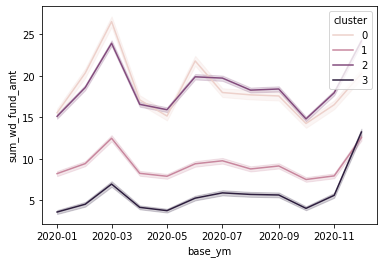

In [228]:
# 클러스터별 인출금액합계 추이
sns.lineplot(x = "base_ym", y = "sum_wd_fund_amt", hue = "cluster", data = data)

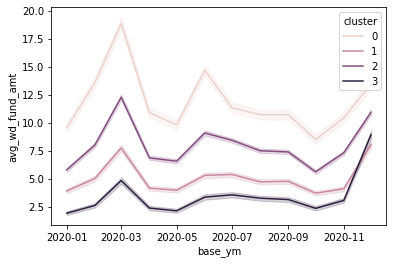

In [229]:
# 클러스터별 인출금액평균 추이
sns.lineplot(x = "base_ym", y = "avg_wd_fund_amt", hue = "cluster", data = data)

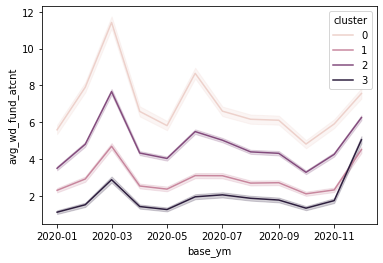

In [230]:
# 클러스터별 인출좌수평균 추이
sns.lineplot(x = "base_ym", y = "avg_wd_fund_atcnt", hue = "cluster", data = data)

투입과 비슷한 양상을 보인다.

### 3. 클러스터별 선호 펀드 파악

클러스터별로 가장 많이 거래한 펀드와 가장 많이 겹치는 펀드를 파악하여 선호하는 펀드를 파악하고자 했습니다.

#### 최빈 거래 펀드
클러스터별로 가장 많이 거래한 펀드를 확인하고 비교했습니다.

In [231]:
# 펀드코드별 거래된 횟수 -최빈 거래 펀드: N440, N400, N600, N220, N2E0
data.groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False)[['gid']].head(10) 

,gid
fund_cd,
N440,26507
N400,26067
N600,24904
N220,24106
N2E0,23599
N5B0,23306
N410,22706
N380,20654
N1A0,20608


In [232]:
# Cluster 0의 최빈 거래 펀드: N440, N600, N400, N5B0, N220, N410, N2E0, __N1A0__, N1E0, N4A0
data[data['cluster']==0].groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False)[['gid']].head(10)

,gid
fund_cd,
N400,5441
N2E0,4992
N440,4808
N220,4639
N380,4545
N600,4204
N1E0,4142
N4D0,4037
N5B0,3946


In [233]:
# Cluster 1의 최빈 거래 펀드 : N400, N2E0, N440, N220, N380, N600, N1E0, __N4D0__, N5B0, N410
data[data['cluster']==1].groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False)[['gid']].head(10)

,gid
fund_cd,
N2E0,8686
N440,8487
N400,8377
N220,7442
N600,7440
N1E0,7137
N410,6448
N6C0,6390
N2A0,6298


In [234]:
# Cluster 2의 최빈 거래 펀드: N400, N440, N600, N220, N410, N4A0, N380, N5B0, N2E0, __N390__
data[data['cluster']==2].groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False)[['gid']].head(10)

,gid
fund_cd,
N440,8428
N400,8427
N600,8328
N220,8266
N410,8189
N5B0,8029
N4A0,8015
N380,7854
N2E0,7572


In [235]:
# Cluster 3의 최빈 거래 펀드: W210, W310, W710, N5B0, W204, N600, N440, W410, W607, N1A0
data[data['cluster']==3].groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False)[['gid']].head(10)

,gid
fund_cd,
W210,6161
W310,5993
W710,5588
N5B0,5481
W204,4958
N600,4932
N440,4784
W410,4726
W607,4422


'클러스터 3'을 제외하면 최빈 거래 펀드가 많이 겹치는 것을 알 수 있습니다.

#### 최다 그룹 거래 펀드


최빈 거래 펀드의 경우 클러스터 내 특정 그룹이 많이 거래한 경우 편향된 값이 나올 수도 있다고 판단하여 클러스터별로 가장 많은 그룹이 거래한 펀드가 무엇인지 확인했습니다.


In [236]:
# 클러스터0의 최다 그룹 거래 펀드
# Cluster 0: N440, N400, N600, N5B0, N220, N410, N2E0, N1A0, N4A0, N1E0
data[data['cluster'] == 0].loc[:, ['gid', 'fund_cd']].drop_duplicates().groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False).head(10)

,gid
fund_cd,
N400,485
N220,451
N2E0,451
N440,450
N380,447
N600,411
N4D0,408
N390,397
N410,382


In [237]:
# 클러스터1의 최다 그룹 펀드
# Cluster 1: N400, N2E0, N220, N380, N440, N600, N4D0, N390, N410, N1E0
data[data['cluster'] == 1].loc[:, ['gid', 'fund_cd']].drop_duplicates().groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False).head(10)

,gid
fund_cd,
N400,770
N2E0,766
N440,751
N220,684
N600,669
N380,628
N1E0,617
N410,581
N6C0,569


In [238]:
# 클러스터2의 최다 그룹 펀드
# Cluster 2: N400, N440, N600, N220, N410, N380, N4A0, N5B0, N390, N2E0
data[data['cluster'] == 2].loc[:, ['gid', 'fund_cd']].drop_duplicates().groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False).head(10)

,gid
fund_cd,
N400,715
N600,710
N440,708
N220,705
N410,702
N380,686
N4A0,685
N5B0,682
N390,670


In [239]:
# 클러스터3의 최다 그룹 펀드
# Clutser 3: W210, W310, W710, N5B0, W104, N600, W204, N440, W410, W311
data[data['cluster'] == 3].loc[:, ['gid', 'fund_cd']].drop_duplicates().groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False).head(10)

,gid
fund_cd,
W210,522
W310,506
W710,475
N5B0,469
W104,466
N600,435
W204,422
N440,421
W410,402


상위 10개의 펀드에 대해 최다 거래 펀드와 비교했으나 큰 차이는 없었습니다.

### 4. 태블로 시각화용 데이터셋 완성

#### 클러스터 정보

In [240]:
# 시각화에 사용될 변수만 추출
cluster_inf = data.loc[:,['cluster','cntr_cnt', 'sum_fee_amt', 'avg_max_pay', 'avg_ch_cntr_cnt', 'fund_cd_num', 'fund_ratio', 'avg_cssc', 'avg_jn_amt', 'in_fund_cnt', 'wd_fund_cnt']]
cluster_inf.head()

,cluster,cntr_cnt,sum_fee_amt,avg_max_pay,avg_ch_cntr_cnt,fund_cd_num,fund_ratio,avg_cssc,avg_jn_amt,in_fund_cnt,wd_fund_cnt
0,0,1,655,75,11.0,31,0.052288,500,4467,1,2
1,0,1,655,75,11.0,31,0.052288,500,4467,0,3
2,0,1,655,75,11.0,31,0.052288,500,4467,1,3
3,0,1,655,75,11.0,31,0.052288,500,4467,1,2
4,0,1,655,75,11.0,31,0.052288,500,4467,0,3


In [241]:
# 레이더차트에 사용되는 변수들 간의 스케일을 맞추기 위해 정규화
scaler = preprocessing.MinMaxScaler()
scaled_cluster = scaler.fit_transform(cluster_inf[cluster_inf.columns.difference(['cluster', 'fund_ratio', 'avg_cssc', 'avg_jn_amt', 'in_fund_cnt', 'wd_fund_cnt'])])
scaled_cluster = pd.DataFrame(scaled_cluster, columns=['cntr_cnt_s', 'sum_fee_amt_s', 'avg_max_pay_s','avg_ch_cntr_cnt_s','fund_cd_num_s'])
scaled_cluster

,cntr_cnt_s,sum_fee_amt_s,avg_max_pay_s,avg_ch_cntr_cnt_s,fund_cd_num_s
0,0.55,0.506849,0.25,0.257143,0.005284
1,0.55,0.506849,0.25,0.257143,0.005284
2,0.55,0.506849,0.25,0.257143,0.005284
3,0.55,0.506849,0.25,0.257143,0.005284
4,0.55,0.506849,0.25,0.257143,0.005284
...,...,...,...,...,...
1166594,0.10,0.363014,0.25,0.114286,0.001341
1166595,0.10,0.363014,0.25,0.114286,0.001341
1166596,0.10,0.363014,0.25,0.114286,0.001341
1166597,0.10,0.363014,0.25,0.114286,0.001341


In [242]:
# 정규화한 변수의 평균값 구하기
cluster_inf = cluster_inf.groupby(['cluster']).mean().reset_index()
cluster_inf.head()

,cluster,cntr_cnt,sum_fee_amt,avg_max_pay,avg_ch_cntr_cnt,fund_cd_num,fund_ratio,avg_cssc,avg_jn_amt,in_fund_cnt,wd_fund_cnt
0,0,2.678864,1954.326700,53.520891,14.857792,39.599011,0.124411,1084.621205,3339.349294,1.843796,7.326210
1,1,2.000620,2077.054234,60.039224,3.838060,29.114976,0.124674,829.461917,3880.173747,1.570426,5.957343
2,2,2.170472,8586.287156,85.118525,4.876075,68.711190,0.195503,746.643463,2995.321747,4.264599,12.239537
3,3,2.013208,857.641880,93.191779,1.741202,26.243981,0.364027,648.419805,2992.901051,1.554044,4.668511


In [243]:
# 변수별 전체 평균값(total) 행 추가
cluster_inf = pd.concat([cluster_inf, pd.DataFrame(cluster_inf.mean()).T], axis = 0)
cluster_inf = cluster_inf.astype({'cluster': 'str'})
cluster_inf.iloc[4, 0] = "total"
cluster_inf

,cluster,cntr_cnt,sum_fee_amt,avg_max_pay,avg_ch_cntr_cnt,fund_cd_num,fund_ratio,avg_cssc,avg_jn_amt,in_fund_cnt,wd_fund_cnt
0,0.0,2.678864,1954.326700,53.520891,14.857792,39.599011,0.124411,1084.621205,3339.349294,1.843796,7.326210
1,1.0,2.000620,2077.054234,60.039224,3.838060,29.114976,0.124674,829.461917,3880.173747,1.570426,5.957343
2,2.0,2.170472,8586.287156,85.118525,4.876075,68.711190,0.195503,746.643463,2995.321747,4.264599,12.239537
3,3.0,2.013208,857.641880,93.191779,1.741202,26.243981,0.364027,648.419805,2992.901051,1.554044,4.668511
0,total,2.215791,3368.827492,72.967605,6.328282,40.917290,0.202154,827.286598,3301.936460,2.308216,7.547900


In [244]:
# 클러스터명 변경
cluster_inf.loc[cluster_inf['cluster'] == '0.0', 'cluster'] = 'MVIP형'
cluster_inf.loc[cluster_inf['cluster'] == '1.0', 'cluster'] = '보험중심형'
cluster_inf.loc[cluster_inf['cluster'] == '2.0', 'cluster'] = '다다익선형'
cluster_inf.loc[cluster_inf['cluster'] == '3.0', 'cluster'] = '주식중심형'

In [245]:
cluster_inf

,cluster,cntr_cnt,sum_fee_amt,avg_max_pay,avg_ch_cntr_cnt,fund_cd_num,fund_ratio,avg_cssc,avg_jn_amt,in_fund_cnt,wd_fund_cnt
0,MVIP형,2.678864,1954.326700,53.520891,14.857792,39.599011,0.124411,1084.621205,3339.349294,1.843796,7.326210
1,보험중심형,2.000620,2077.054234,60.039224,3.838060,29.114976,0.124674,829.461917,3880.173747,1.570426,5.957343
2,다다익선형,2.170472,8586.287156,85.118525,4.876075,68.711190,0.195503,746.643463,2995.321747,4.264599,12.239537
3,주식중심형,2.013208,857.641880,93.191779,1.741202,26.243981,0.364027,648.419805,2992.901051,1.554044,4.668511
0,total,2.215791,3368.827492,72.967605,6.328282,40.917290,0.202154,827.286598,3301.936460,2.308216,7.547900


In [246]:
cluster_inf.to_csv("/content/drive/MyDrive/miraeasset/대시보드용 데이터/cluster_inf.csv", header = True, index = False)

#### 펀드 및 키워드 시각화를 위한 전처리

In [247]:
# 펀드별 핵심 키워드 데이터 불러오기
keyword = pd.read_csv("/content/drive/MyDrive/miraeasset/fund_keyword.csv", encoding = 'euc-kr')

In [248]:
keyword = keyword.loc[:, ['fund_cd', 'fund_nm', 'keyword']]
keyword.head(3)

,fund_cd,fund_nm,keyword
0,N2C0,아시아인프라,"['인프라', '코로나19', '아시아', '배당', '섹터', '종식', '미국'..."
1,N5A0,MMF형,"['단기', '콜론', '금리', '양도', '증서', '금융', '매수', '예금..."
2,N1B0,혼합형,"['기여', '실적', '증감', '국내', '가능', '업종', '반도체', '예..."


In [249]:
# 데이터에 병합
data = pd.merge(data, keyword, how = 'left', left_on = ['fund_cd', 'fund_nm'], right_on = ['fund_cd', 'fund_nm'])
data.head(3)

,gid,base_ym,product_cd,age_cd,channel_cd,gender,job_cd,pay_prd,loan_yn,rider,rcpt_cd,cntr_cnt,signgu_cd,avg_jn_amt,avg_cssc,sum_fee_amt,avg_max_pay,avg_ch_cntr_cnt,cntr_no_cnt,fund_avg_income_ratio,fund_min_income_ratio,fund_1q_income_ratio,fund_med_income_ratio,fund_3q_income_ratio,fund_max_income_ratio,fund_cd,avg_ch_fund_ratio,avg_bs_fund_ratio,avg_add_fund_ratio,in_fund_cnt,sum_in_fund_amt,min_in_fund_amt,max_in_fund_amt,med_in_fund_amt,avg_in_fund_amt,sum_in_fund_atcnt,min_in_fund_atcnt,max_in_fund_atcnt,med_in_fund_atcnt,avg_in_fund_atcnt,wd_fund_cnt,sum_wd_fund_amt,min_wd_fund_amt,max_wd_fund_amt,med_wd_fund_amt,avg_wd_fund_amt,sum_wd_fund_atcnt,min_wd_fund_atcnt,max_wd_fund_atcnt,med_wd_fund_atcnt,avg_wd_fund_atcnt,fund_price,fund_nm,fund_set_dt,operation_rsk,operation_conm,fund_expln,stck_expln,finan_bond_expln,fund_aset_cd,fund_stle_cd,insur_as_fund_cd,fund_diff_cd,finan_bond_cd,feh_cd,fund_cd_num,fund_stle_num,fund_ratio,cluster,keyword
0,7766143.0,2020-11-01,2,41_55,2,0,B,1,0,1,1,1,1,4467,500,655,75,11.0,15,17.54,2.56,7.5,16.0,21.0,45.63,N2C0,NaN,NaN,NaN,1,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1313.65,아시아인프라,20080415,3,이스트스프링자산운용,자산의 60% 이상을 아시아 국가의 인프라관련 주식 및 아시아국가 인프라 주식을 주...,60% 이상을 아시아 각국의 인프라 산업과 관련된 주식 및 주식형 펀드,"40% 이내에서 현예금(외화 현예금 포함), MMF 등을 포함한 유동성 자산",8,6,KLVL3400W15,0,2,2,31,15,0.052288,0,"['인프라', '코로나19', '아시아', '배당', '섹터', '종식', '미국'..."
1,7766143.0,2020-03-01,2,41_55,2,0,B,1,0,1,1,1,1,4467,500,655,75,11.0,15,9.82,0.12,4.0,8.0,12.5,27.71,N5A0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1438.67,MMF형,20040607,5,KB자산운용,"MMF형 펀드, 콜론 등의 단기유동성 금융자산에 90% 이상 투자",투자하지 않음,단기유동성 금융자산,4,9,KLVL3400V14,0,1,2,31,15,0.052288,0,"['단기', '콜론', '금리', '양도', '증서', '금융', '매수', '예금..."
2,7766143.0,2020-05-01,2,41_55,2,0,B,1,0,1,1,1,1,4467,500,655,75,11.0,15,5.70,-11.87,1.0,5.0,10.5,19.89,N1B0,NaN,NaN,NaN,1,11.0,11.0,11.0,11.0,11.0,5.0,5.0,5.0,5.0,5.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2388.41,혼합형,20040607,3,교보악사자산운용,"자산의 50%를 주식 및 주식형펀드, 50%를 채권 및 채권형펀드에 투자","50%를 주식 및 주식형 펀드, 20% 범위 내에서 증감이 가능","50%를 채권 및 채권형 펀드, 20% 범위 내에서 증감이 가능, 현예금, MMF ...",1,2,KLVL3400V12,1,2,2,31,15,0.052288,0,"['기여', '실적', '증감', '국내', '가능', '업종', '반도체', '예..."


In [250]:
# 클러스터별로 거래한 펀드와 키워드만 추출
zero_fund = data[data['cluster'] == 0]
first_fund = data[data['cluster'] == 1]
sec_fund = data[data['cluster'] == 2]
thd_fund = data[data['cluster'] == 3]

In [251]:
# 클러스터 거래 상위 10개 펀드 중 3개 이상의 클러스터에서 겹치는 펀드 제외
zero_fund = zero_fund[~zero_fund['fund_cd'].isin(['N440', 'N5B0', 'N600', 'N400', 'N220', 'N410', 'N2E0'])].reset_index(drop = True)
first_fund = first_fund[~first_fund['fund_cd'].isin(['N440', 'N5B0', 'N600', 'N400', 'N220', 'N410', 'N2E0'])].reset_index(drop = True)
sec_fund = sec_fund[~sec_fund['fund_cd'].isin(['N440', 'N5B0', 'N600', 'N400', 'N220', 'N410', 'N2E0'])].reset_index(drop = True)
thd_fund = thd_fund[~thd_fund['fund_cd'].isin(['N440', 'N5B0', 'N600', 'N400', 'N220', 'N410', 'N2E0'])].reset_index(drop = True)

In [252]:
# 클러스터별 상위 키워드 25개 추출
# 클러스터1
zero_keyword = []

for i in range(zero_fund.shape[0]):
  zero_keyword.extend(ast.literal_eval(zero_fund.loc[i, 'keyword']))

counter_0 = collections.Counter(zero_keyword)
counter_0.most_common(n = 25)

[('미국', 53176),
 ('코로나19', 52671),
 ('섹터', 46264),
 ('종식', 42562),
 ('수익', 24193),
 ('금리', 23482),
 ('업종', 22786),
 ('성장', 20415),
 ('장기', 19893),
 ('상승', 18696),
 ('기업', 18370),
 ('아시아', 17228),
 ('국내', 16413),
 ('이머징', 15824),
 ('글로벌', 15704),
 ('경기', 15517),
 ('경제', 15508),
 ('기술', 15478),
 ('반도체', 13766),
 ('국채', 13155),
 ('배분', 12872),
 ('달러', 12724),
 ('중국', 11768),
 ('국내외', 11647),
 ('하이일드', 11507)]

In [253]:
# 클러스터1
first_keyword = []

for i in range(first_fund.shape[0]):
  first_keyword.extend(ast.literal_eval(first_fund.loc[i, 'keyword']))

counter_1 = collections.Counter(first_keyword)
counter_1.most_common(n = 25)

[('코로나19', 83166),
 ('미국', 82546),
 ('섹터', 72531),
 ('종식', 68502),
 ('업종', 39559),
 ('수익', 39455),
 ('금리', 36711),
 ('장기', 31238),
 ('성장', 31016),
 ('국내', 30202),
 ('기업', 30171),
 ('상승', 29967),
 ('아시아', 27718),
 ('글로벌', 26146),
 ('이머징', 25020),
 ('경제', 24432),
 ('반도체', 24396),
 ('기술', 24201),
 ('배분', 24181),
 ('경기', 22373),
 ('달러', 21857),
 ('증감', 21311),
 ('중국', 20496),
 ('국내외', 20229),
 ('하이일드', 19898)]

In [254]:
# 클러스터2
sec_keyword = []

for i in range(sec_fund.shape[0]):
  sec_keyword.extend(ast.literal_eval(sec_fund.loc[i, 'keyword']))

counter_2 = collections.Counter(sec_keyword)
counter_2.most_common(n = 25)

[('코로나19', 164132),
 ('미국', 143497),
 ('섹터', 138199),
 ('종식', 122439),
 ('수익', 83258),
 ('성장', 78318),
 ('국내외', 76648),
 ('업종', 75830),
 ('금리', 70938),
 ('기업', 63827),
 ('상승', 61850),
 ('아시아', 58935),
 ('국내', 57328),
 ('글로벌', 56586),
 ('배분', 56533),
 ('장기', 56062),
 ('반도체', 49792),
 ('산업', 48406),
 ('경기', 46930),
 ('이머징', 46180),
 ('국가', 44970),
 ('기술', 44067),
 ('중국', 43710),
 ('국채', 43630),
 ('경제', 41340)]

In [255]:
# 클러스터3
thd_keyword = []

for i in range(thd_fund.shape[0]):
  thd_keyword.extend(ast.literal_eval(thd_fund.loc[i, 'keyword']))

counter_3 = collections.Counter(thd_keyword)
counter_3.most_common(n = 25)

[('국내외', 67212),
 ('코로나19', 55406),
 ('섹터', 50270),
 ('성장', 47787),
 ('미국', 45884),
 ('종식', 42865),
 ('수익', 38494),
 ('업종', 29997),
 ('산업', 29375),
 ('기업', 28607),
 ('아시아', 27214),
 ('글로벌', 25895),
 ('가능', 25343),
 ('배분', 24656),
 ('금리', 24627),
 ('중국', 22189),
 ('장기', 21965),
 ('국가', 21621),
 ('반도체', 21514),
 ('국내', 18312),
 ('태평양', 17954),
 ('지수', 17740),
 ('세계', 17079),
 ('일본', 16992),
 ('인도', 16745)]

클러스터간 상위 키워드가 겹치기 때문에 유의미해보이는 키워드 15개를 공통적으로 추출해 사용했습니다.  

### 코로나19, 국내외, 성장, 미국, 아시아, 글로벌, 중국, 반도체, 국내, 이머징, 기술, 장기, 국채, 하이일드, 태평양


In [256]:
# 최종 키워드리스트
keyword_list = ['코로나19', '국내외', '성장', '미국', '아시아', '글로벌', '중국', '반도체', '국내', '이머징', '기술', '장기', '국채', '하이일드', '태평양']

# 모든 클러스터에서 최종 키워드의 카운트수를 나타내는 데이터프레임 만들기
total_keyword = pd.DataFrame(index=range(0, 60), columns=['cluster','keyword', 'count'])

In [257]:
for i, word in enumerate(keyword_list):
  total_keyword.loc[i, 'cluster'] = '0'
  total_keyword.loc[i, 'keyword'] = word
  total_keyword.loc[i, 'count'] = counter_0[word]

for i, word in enumerate(keyword_list):
  total_keyword.loc[i+15, 'cluster'] = '1'
  total_keyword.loc[i+15, 'keyword'] = word
  total_keyword.loc[i+15, 'count'] = counter_1[word]

for i, word in enumerate(keyword_list):
  total_keyword.loc[i+30, 'cluster'] = '2'
  total_keyword.loc[i+30, 'keyword'] = word
  total_keyword.loc[i+30, 'count'] = counter_2[word]

for i, word in enumerate(keyword_list):
  total_keyword.loc[i+45, 'cluster'] = '3'
  total_keyword.loc[i+45, 'keyword'] = word
  total_keyword.loc[i+45, 'count'] = counter_3[word]

In [258]:
total_keyword.head()

,cluster,keyword,count
0,0,코로나19,52671
1,0,국내외,11647
2,0,성장,20415
3,0,미국,53176
4,0,아시아,17228


In [259]:
# 전체 펀드 중 키워드가 포함된 펀드만 추출
keyword_fund = pd.DataFrame(index=range(0, 154*15), columns=['fund_cd','keyword'])
s = 0

for i in range(keyword.shape[0]):
  for word in keyword_list:
    if word in ast.literal_eval(keyword.loc[i, 'keyword']):
      keyword_fund.loc[s, 'fund_cd'] = keyword.loc[i, 'fund_cd']
      keyword_fund.loc[s, 'keyword'] = word
      s += 1

In [260]:
keyword_fund = keyword_fund.drop_duplicates().iloc[:292,:]
keyword_fund

,fund_cd,keyword
0,N2C0,코로나19
1,N2C0,미국
2,N2C0,아시아
3,N1B0,반도체
4,N1B0,국내
...,...,...
287,W307,국내외
288,W307,아시아
289,N9H0,국내
290,N250,중국


In [261]:
# 각 클러스터별로 (겹치는 펀드 제외) 상위 20개 펀드 뽑기
zero_count = zero_fund.groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False).reset_index()
first_count = first_fund.groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False).reset_index()
sec_count = sec_fund.groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False).reset_index()
thd_count = thd_fund.groupby(['fund_cd']).count().sort_values(by = ['gid'], ascending = False).reset_index()

In [262]:
# 15개 키워드를 포함하는 펀드 중 상위 20개
zero_count = zero_count[zero_count['fund_cd'].isin(set(keyword_fund['fund_cd'].tolist()))].head(20).loc[:,'fund_cd'].tolist()
first_count = first_count[first_count['fund_cd'].isin(set(keyword_fund['fund_cd'].tolist()))].head(20).loc[:,'fund_cd'].tolist()
sec_count = sec_count[sec_count['fund_cd'].isin(set(keyword_fund['fund_cd'].tolist()))].head(20).loc[:,'fund_cd'].tolist()
thd_count = thd_count[thd_count['fund_cd'].isin(set(keyword_fund['fund_cd'].tolist()))].head(20).loc[:,'fund_cd'].tolist()

In [263]:
# 전체 키워드 중에서 상위 셀에서 뽑은 단어들 추출
zero_fund = keyword_fund[keyword_fund['fund_cd'].isin(zero_count)].reset_index(drop = True)
first_fund = keyword_fund[keyword_fund['fund_cd'].isin(first_count)].reset_index(drop = True)
sec_fund = keyword_fund[keyword_fund['fund_cd'].isin(sec_count)].reset_index(drop = True)
thd_fund = keyword_fund[keyword_fund['fund_cd'].isin(thd_count)].reset_index(drop = True)

In [264]:
# 클러스터별 데이터셋 생성 
zero_fund['cluster'] = '0'
first_fund['cluster'] = '1'
sec_fund['cluster'] = '2'
thd_fund['cluster'] = '3'

cluster_fund = pd.concat([zero_fund, first_fund, sec_fund, thd_fund], axis = 0)
cluster_fund.head(3)

,fund_cd,keyword,cluster
0,N4C0,코로나19,0
1,N4C0,미국,0
2,N750,미국,0


In [265]:
# 데이터 병합
final_keyword = pd.merge(total_keyword, cluster_fund, left_on= ['cluster', 'keyword'], right_on= ['cluster', 'keyword'], how='outer')

In [266]:
# 상위 20개 펀드 중 해당 키워드를 가진 펀드가 존재하지 않은 경우
final_keyword[final_keyword['fund_cd'].isnull()]

,cluster,keyword,count,fund_cd
8,0,국내외,11647,NaN
50,0,태평양,4416,NaN
60,1,국내외,20229,NaN
102,1,태평양,7234,NaN
110,2,국내외,76648,NaN
206,3,하이일드,5770,NaN


상위 20게 펀드 중에 해당 키워드를 가진 펀드가 존재하지 않을 경우 NaN이 된다.  
'클러스터 0'과 '1'의 경우, `국내외`, `태평양` 이라는 키워드를 가진 펀드가 상위 20개 내에 존재하지 않고, '클러스터 2'는 `국내외`, '클러스터 3'은 `하이일드`라는 키워드를 가진 펀드가 존재하지 않는다.

In [267]:
# 클러스터별 최종 펀드/키워드 데이터셋 생성
final_keyword = pd.merge(final_keyword, keyword, how = 'left', left_on = 'fund_cd', right_on = 'fund_cd')
final_keyword.rename(columns = {'keyword_x' : 'keyword', 'keyword_y' : 'keyword_list'}, inplace = True)
final_keyword = final_keyword[final_keyword.columns.difference(['keyword_list'])]

In [268]:
final_keyword

,cluster,count,fund_cd,fund_nm,keyword
0,0,52671,N4C0,글로벌멀티인컴,코로나19
1,0,52671,N380,미국주식형,코로나19
2,0,52671,N4A0,해외성장형,코로나19
3,0,52671,N3C0,미국인컴앤그로쓰,코로나19
4,0,52671,N3A0,유럽주식형,코로나19
...,...,...,...,...,...
204,3,12390,N500,국내채권형,국채
205,3,12390,W111,글로벌채권형,국채
206,3,5770,NaN,NaN,하이일드
207,3,17954,W311,아시아퍼시픽컨슈머혼합자산배분형,태평양


In [269]:
# 펀드 자산구분코드, 펀드 스타일구분코드, 펀드 설명 변수 추가
fund_data = data.loc[:, ['fund_cd', 'fund_aset_cd', 'fund_stle_cd', 'fund_expln']].drop_duplicates().reset_index(drop = True)
fund_data.head(3)

,fund_cd,fund_aset_cd,fund_stle_cd,fund_expln
0,N2C0,8,6,자산의 60% 이상을 아시아 국가의 인프라관련 주식 및 아시아국가 인프라 주식을 주...
1,N5A0,4,9,"MMF형 펀드, 콜론 등의 단기유동성 금융자산에 90% 이상 투자"
2,N1B0,1,2,"자산의 50%를 주식 및 주식형펀드, 50%를 채권 및 채권형펀드에 투자"


In [270]:
fund_data['fund_aset_cd'] = fund_data['fund_aset_cd'].astype(str)
fund_data['fund_stle_cd'] = fund_data['fund_stle_cd'].astype(str)

In [271]:
fund_data['fund_stle_cd'] = fund_data['fund_stle_cd'].map({'1':'국내인덱스주식', '2': '국내성장주식', '3': '국내가치주식', '4': '국내배당주식', '5': '글로벌주식',
                               '6': '이머징주식', '7': '컨슈머주식', '8': '국내일반채권', '9': '국내MMF', '10': '글로벌채권',
                               '11': '이머징채권', '12': '하이일드채권', '13': '절대수익형', '14': '원자재', '15': '부동산',
                               '16': '자산배분형', '17': '선진국주식', '18': '선진국채권'}, na_action = None)

In [272]:
fund_data['fund_aset_cd'] = fund_data['fund_aset_cd'].map({'1':'국내주식혼합', '2': '국내주식', '3': '국내채권혼합', '4': '국내채권', '5': '포트폴리오',
                               '6': '대안투자', '7': '해외주식혼합', '8': '해외주식', '9': '해외채권', '10': '해외채권혼합'}, na_action = None)

In [273]:
final_keyword = pd.merge(final_keyword, fund_data, how = 'left', left_on = 'fund_cd', right_on = 'fund_cd')

In [274]:
final_keyword.loc[final_keyword['cluster'] == '0', 'cluster'] = 'MVIP형'
final_keyword.loc[final_keyword['cluster'] == '1', 'cluster'] = '보험중심형'
final_keyword.loc[final_keyword['cluster'] == '2', 'cluster'] = '다다익선형'
final_keyword.loc[final_keyword['cluster'] == '3', 'cluster'] = '주식중심형'

In [275]:
final_keyword

,cluster,count,fund_cd,fund_nm,keyword,fund_aset_cd,fund_stle_cd,fund_expln
0,MVIP형,52671,N4C0,글로벌멀티인컴,코로나19,해외채권혼합,글로벌채권,"전세계의 고배당 주식, 고수익 채권 등 안정적인 배당 및 이자수익 등을 제공하는 다..."
1,MVIP형,52671,N380,미국주식형,코로나19,해외주식,선진국주식,미국 상장 주식에 주로 투자하여 장기적인 자본이익 추구
2,MVIP형,52671,N4A0,해외성장형,코로나19,해외주식,글로벌주식,"자산의 80%를 해외주식 및 해외주식형 펀드, 20%를 해외채권 및 해외채권형 펀드..."
3,MVIP형,52671,N3C0,미국인컴앤그로쓰,코로나19,해외채권혼합,선진국주식,"순자산의 60% 이상을 미국의 주식(커버드콜 포함) 및 전환사채, 하이일드 채권 등..."
4,MVIP형,52671,N3A0,유럽주식형,코로나19,해외주식,선진국주식,순자산의 60% 이상을 유럽 지역의 주식 또는 이러한 주식을 주된 투자대상으로 하는...
...,...,...,...,...,...,...,...,...
204,주식중심형,12390,N500,국내채권형,국채,국내채권,국내일반채권,정부 발행 국채와 정부 보증 공사채 등에 주로 투자하여 안정적인 이자수익과 금리변동...
205,주식중심형,12390,W111,글로벌채권형,국채,해외채권,글로벌채권,"선진국, 이머징 지역의 국채 및 회사채, 국고채 등을 활용한 적극적인 자산배분전략을..."
206,주식중심형,5770,NaN,NaN,하이일드,NaN,NaN,NaN
207,주식중심형,17954,W311,아시아퍼시픽컨슈머혼합자산배분형,태평양,해외주식혼합,컨슈머주식,"아시아 태평양 국가(일본제외)의 높은 성장성, 중산층확대 등에 따른 소비성장의 수혜..."


In [276]:
final_keyword.to_csv('/content/drive/MyDrive/miraeasset/대시보드용 데이터/final_keyword.csv', header=True, index = False)

#### 클러스터 예측

대시보드에서 자신의 투자성향을 입력하면 입력값에 맞는 클러스터를 반환하기 위해 임의의 데이터를 생성하여 클러스터를 예측하였습니다. 이를 활용하여 투자성향 예측 서비스에 활용하였습니다.

In [277]:
from itertools import product

# 임의의 데이터의 구간 설정
def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

In [278]:
# 각 구간 별 데이터에 대해 클러스터 예측
pred_data = {'avg_ch_cntr_cnt': list(range(1, 14, 3)),'avg_jn_amt': list(range(3000, 4000, 200)),
             'fund_cd_num': list(range(20, 70, 10)),'fund_ratio' : np.arange(0.1, 0.6, 0.1)}
pred_data = expand_grid(pred_data)

pred_data

,avg_ch_cntr_cnt,avg_jn_amt,fund_cd_num,fund_ratio
0,1,3000,20,0.1
1,1,3000,20,0.2
2,1,3000,20,0.3
3,1,3000,20,0.4
4,1,3000,20,0.5
...,...,...,...,...
620,13,3800,60,0.1
621,13,3800,60,0.2
622,13,3800,60,0.3
623,13,3800,60,0.4


In [279]:
# 클러스터링을 위한 정규화
result_cluster = cluster_data.copy()
result_cluster = result_cluster[result_cluster.columns.difference(['cluster'])]

scaler = preprocessing.MinMaxScaler()
scaler.fit(result_cluster[result_cluster.columns.difference(['gid'])])
pred_data_std = scaler.transform(pred_data)

pred_data_std = pd.DataFrame(pred_data_std, columns=['avg_ch_cntr_cnt', 'fund_cd_num', 'avg_jn_amt', 'fund_ratio'])
pred_data_std.head(3)

,avg_ch_cntr_cnt,fund_cd_num,avg_jn_amt,fund_ratio
0,0.05,0.037961,0.152381,0.1
1,0.05,0.037961,0.152381,0.2
2,0.05,0.037961,0.152381,0.3


In [280]:
# 클러스터 예측
pred_y = km.predict(pred_data_std)
pred_data['cluster'] = pred_y
pred_data.head(3)

,avg_ch_cntr_cnt,avg_jn_amt,fund_cd_num,fund_ratio,cluster
0,1,3000,20,0.1,1
1,1,3000,20,0.2,1
2,1,3000,20,0.3,3


In [281]:
# cluster column 생성
pred_data['cluster'] = pred_data['cluster'].astype('str')

In [282]:
# 클러스터별 데이터 개수 확인
pred_data.groupby('cluster').count()

,avg_ch_cntr_cnt,avg_jn_amt,fund_cd_num,fund_ratio
cluster,,,,
0,195,195,195,195
1,100,100,100,100
2,185,185,185,185
3,145,145,145,145


In [283]:
pred_data.to_csv('predict_data.csv', header = True, index = False)

본 저작물의 저작권은 Apache License v2.0을 따릅니다.